In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import csv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/data-truncated-1203/data_truncated_1203_csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101216.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101114.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500119046.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500119074.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101092.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500119086.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101042.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500119043.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101093.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101010.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101008.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101015.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101040.csv
/kaggle/input/data-truncated-1203/data_truncated_1203_csv/500101

In [15]:
# Import Libraries
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

In [16]:
idx = {'10/11_23:40': 719,'10/16_00:00': 720,'10/19_00:00': 936,'10/20_23:40': 1079,'10/25_00:00': 1080,'11/18_23:40': 2879,'11/19_00:00': 2880,'11/26_00:00': 3384,'12/02_00:00': 3816,'12/03_23:40': 3959,'12/07_00:00': 4176}

In [17]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    one_day_period = 72
    lookforward = 1
    for i in range(len(dataset)-(lookback+one_day_period)):
        if i + lookback + lookforward > idx['10/11_23:40'] and i < idx['10/16_00:00']:
            continue
        if i + lookback + lookforward > idx['10/20_23:40'] and i < idx['10/25_00:00']:
            continue
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback:i+lookback+lookforward][:,-1] # ratio at [:,-1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [18]:
def train_valid_split(timeseries):
    # train-valid split with 10/2~11/16 [0:2734], 11/17~11/30[2734:], 11/26~12/09[3384:]
    # 10/2 ~ 10/11 [:711]
#     train_size = idx['11/19_00:00']
    train_size = idx['11/26_00:00']
    valid_size = len(timeseries) - train_size
    train, valid = timeseries[:train_size], timeseries[train_size:]
    print(len(train), len(valid))
    # window size approximately = 3 days
    lookback = 72 * 2
    X_train, y_train = create_dataset(train, lookback=lookback)
    X_valid, y_valid = create_dataset(valid, lookback=lookback)
    # X_test, y_test = create_dataset(test, lookback=lookback)
    print("X.shape = [batch, seq, features], y.shape = [batch, seq]")
#     print(y_train[0])
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    return X_train, y_train, X_valid, y_valid

In [19]:
def create_test_dataset(dataset, new_data):
    """
     Args:
        dataset: A numpy array of time series, size = 144
        new data: New prediction append to dataset to shift window
    """
    X = []
    if new_data == None:
        X = dataset
    else:
        X = np.append(dataset, [np.array(new_data)],axis=0)
        X = X[1:]
    return torch.tensor(np.array(X))

## Build a basic RNN model

In [20]:
class UBikeRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, drop_prob, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, dropout=drop_prob, batch_first=True)    
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
#         print(x.size(0)) # x.size(0) = batch size
        hidden = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        x = x.view(len(x),1,-1)
#         print(x.shape)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        out = self.sig(out)
        return out

In [21]:
class UBikeLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, drop_prob, output_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = layer_dim
        self.output_size = output_dim
        
        # initialize LSTM   
        self.block = nn.Sequential(
            nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=drop_prob, batch_first=True, bidirectional=False),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=drop_prob, batch_first=True, bidirectional=False)
        # the output of LSTM is classified by linear and sigmoid functions
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device) # hidden state
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device) # internal state
        lstm_out, (hn, cn)  = self.lstm(x)
#         hn = hn.view(-1, self.hidden_dim) # reshaping the data for Dense layer next
#         print(f"lstm_out.shape = {lstm_out.shape}") # [32, 144, 128] (N=batch size,L=seq,H=hidden) 
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = lstm_out[:,-1,:]
        out = self.linear(lstm_out) # [32,hidden=128] to [32,output=72]
        out = self.sigmoid(out)
        
        return out

## Loss function

In [22]:
def getLoss(pred, label):
#     loss = torch.mean(3 * torch.abs(pred-label) * (torch.abs(pred-1/3) + torch.abs(pred-2/3)))
    loss = torch.mean(torch.square(pred-label))
#     print(f"loss = {loss}")
    return loss

## Configurations

In [23]:
config = {
    "batch_size": 32,
    "data_filepath": '/kaggle/input/stop001-sorted/500101001_sorted.csv',
    "inference_filepath": '/kaggle/input/stop001-1204-1210-inf/stop001_inf_1204_to_1210.csv',
    "epochs": 150,
    "learning_rate": 1e-4,
    "weight_decay": 5e-3,
    "save_dir": "/kaggle/working/",
    "model_name": "stop001-RNN-v1.ckpt",
    "early_stop": 150,
}
# model parameters
window_size = 72 * 2
input_dim =  5 # number of features !!!
hidden_dim = 128   # the hidden dim
layer_dim = 3   # the number of hidden layers
output_dim = 1
drop_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Start Training!!!

In [24]:
def train(model, config, train_loader, valid_loader, device):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay']) 
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=1,T_mult=2)

    n_epochs, best_loss, step, early_stop_count = config['epochs'], 10000, 0, 0
    actual_ratio = []
    pred_ratio = []
    mse_loss_train = []
    mse_loss_val = []
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
#         train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_loader:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x) 
#             print(f"pred.shape = {pred.shape}, y.shape = {y.shape}") # [32,72]
#             print(f"pred = {pred.detach().cpu()[0][0]}, y = {y[0][0]}")
            loss = getLoss(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
#             train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
#             train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        mse_loss_train.append(mean_train_loss)
        
        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = getLoss(pred, y)
            
            if epoch == n_epochs - 1:
                actual_ratio.append(y[0][0].item())
                pred_ratio.append(pred.detach().cpu()[0][0])
            loss_record.append(loss.item())
        
        if epoch == n_epochs - 1:
            plt.plot(actual_ratio)
            plt.plot(pred_ratio)
            # plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
            plt.legend(['actual', 'predict'])
            plt.title("Train / Valid")
#             plt.savefig("Train/Valid.png")
            plt.show()
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        mse_loss_val.append(mean_valid_loss)
        # Note that step should be called after validate()
        scheduler.step(mean_valid_loss)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_dir'] + config['model_name']) # Save your best model
            if(epoch % 10 == 0):
                print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        if(epoch % 10 == 0):
            print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        # writer.add_scalar('Loss/valid', mean_valid_loss, step)

            if early_stop_count >= config['early_stop']:
                print('\nModel is not improving, so we halt the training session.')
                print('best loss {:.3f}...'.format(best_loss))
                return
            
    plt.plot(mse_loss_train)
    plt.plot(mse_loss_val)
    plt.title("MSE loss = {:.3f}".format(best_loss))
    plt.legend(['train', 'valid'])
#     plt.savefig('mse_loss.png')
    plt.show()
            

## Inference part

In [25]:
def predict(test_dataset, test_loader, model, device, output_path, stop_name):
    model.eval() # Set your model to evaluation mode.
    preds = []
    tots = []
    titles = []
    ratio_list = test_dataset[:,-1].tolist()
#     test_dataset = timeseries[-window_size:]   # last 144 (2 days) dataset
#     print(np.array(test_dataset).shape) # (144, 7)

    i=0
    month = 12
    for month,day,weekday,hr,min,act,tot,title in test_loader:
        month = month.item()
        tot = tot.tolist()
        title = list(title)
        
        if i == 0:
            x = create_test_dataset(test_dataset, None)
        else: 
            x = create_test_dataset(test_dataset, [weekday.item(),hr.item(),min.item(),act.item(),ratio_list[-1]])
        test_dataset = x
        x = x.unsqueeze(0)
#         print(f"x.shape={x.shape}") # [1, 144, 7]
        x = x.to(torch.float32)
        x = x.to(device)      
        tots = tots + tot
        titles = titles + title
        with torch.no_grad():  
            pred = model(x)  
#             print(f"pred.tolist()[-1][-1] = {pred.tolist()[-1][-1]}")
            ratio_list.append(pred.detach().cpu()[0][0].item())
            preds.append(pred.detach().cpu())
        i+=1
    preds = ratio_list[window_size:]
    print(len(preds), len(tots), len(titles))
    
    plt.plot(ratio_list)
    plt.title("Predictions")
    plt.show()
    plt.close()
    
    plt.plot(preds)
    if month == 12:
#         plt.title("pred_stop_" + stop + "_1204_1210" +".png")
        plt.title("pred_stop_" + stop + "_1211_1217" +".png")
    elif month == 10:
        plt.title("pred_stop_" + stop + "_1021_1024" +".png")
#     plt.savefig(stop + '_' + str(month) +".png")
    plt.show()
    plt.close()
    assert len(preds) == len(tots)
    assert len(tots) == len(titles)
    prediction = []
    if month == 12:
        prediction = [['id','sbi']]
    for (pred, tot, title) in zip(preds, tots, titles):
        title = title.split('_')
        real_title = title[0] + '_' + stop + '_' + title[2]
#         print(pred, tot, pred*tot)
        prediction.append([real_title, pred*tot])
    
    with open(output_path, 'a', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
        writer = csv.writer(file)
        writer.writerows(prediction) # Use writerows for nested list
    
    return

## Running ...

Start training stop 500101216

(4392, 5)
3384 1008
X.shape = [batch, seq, features], y.shape = [batch, seq]
torch.Size([2878, 144, 5]) torch.Size([2878, 1])
torch.Size([647, 144, 5]) torch.Size([647, 1])
Saving model with loss 0.093...
Epoch [1/150]: Train loss: 0.0954, Valid loss: 0.0929
Saving model with loss 0.056...
Epoch [11/150]: Train loss: 0.0379, Valid loss: 0.0561
Epoch [21/150]: Train loss: 0.0251, Valid loss: 0.0408
Epoch [31/150]: Train loss: 0.0189, Valid loss: 0.0282
Saving model with loss 0.024...
Epoch [41/150]: Train loss: 0.0160, Valid loss: 0.0236
Saving model with loss 0.019...
Epoch [51/150]: Train loss: 0.0139, Valid loss: 0.0192
Epoch [61/150]: Train loss: 0.0120, Valid loss: 0.0181
Epoch [71/150]: Train loss: 0.0107, Valid loss: 0.0166
Epoch [81/150]: Train loss: 0.0098, Valid loss: 0.0157
Epoch [91/150]: Train loss: 0.0091, Valid loss: 0.0149
Epoch [101/150]: Train loss: 0.0083, Valid loss: 0.0144
Epoch [111/150]: Train loss: 0.0081, Valid loss: 0.0157
Epoch [

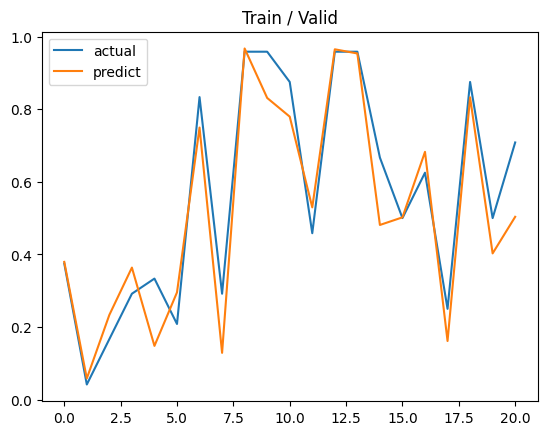

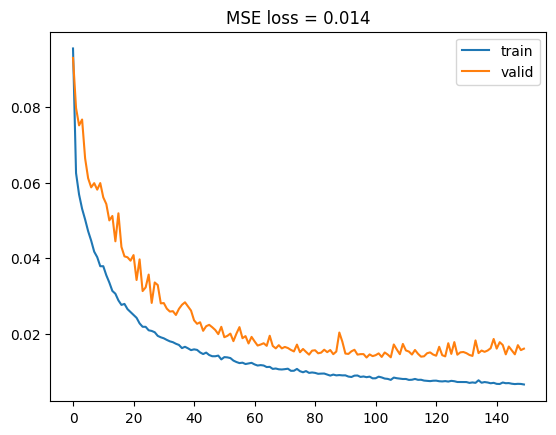

Start predicting stop 500101216

from 1210 to 1217...
504 504 504


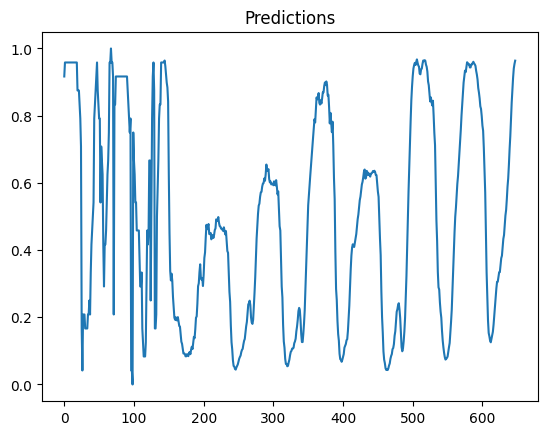

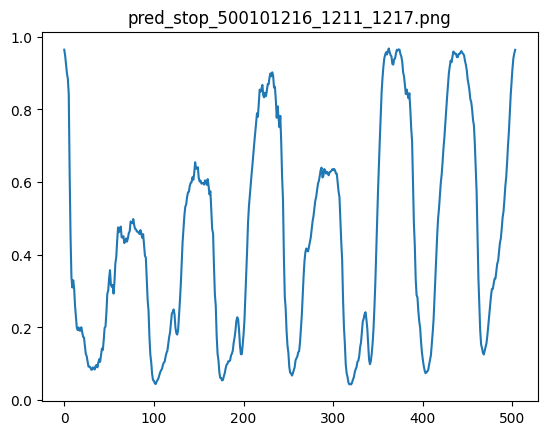

from 1021 to 1024...
288 288 288


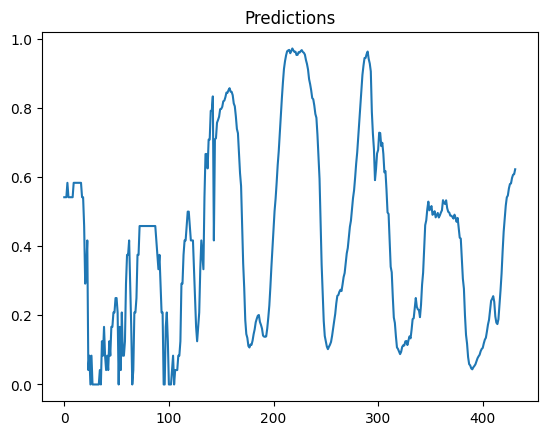

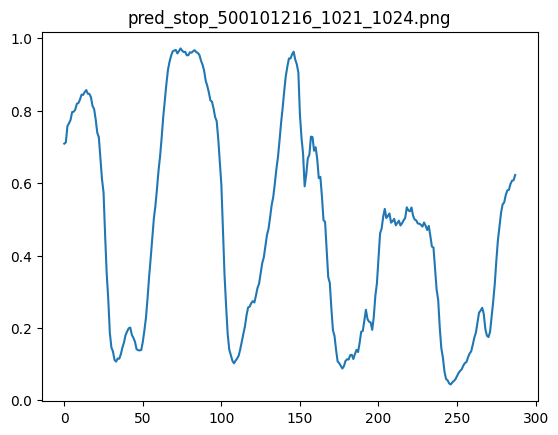

Finish predicting stop 500101216

Prgress 1/112



In [26]:
# Visualize input dataset
# Iterate through 112 stops
i=0
for dirname, _, filenames in os.walk('/kaggle/input/dataset-filled/dataset_filled'):
    for filename in filenames:
        stop = filename.split('.')[0]
#         if stop != '500101216': continue
        config["model_name"] = "stop-" + stop + "-RNN-v1.ckpt"
        output_path = 'lstm_pred_' + stop + '.csv'
        print("Start training stop " + stop + "\n")
#         df = pd.read_csv('/kaggle/input/data-truncated-1203/data_truncated_1203_csv/' + filename)
        df = pd.read_csv('/kaggle/input/data-truncated-1209/data_truncated_1209_csv/' + filename)
#         df_inf = pd.read_csv("/kaggle/input/stop001-1204-1210-inf/stop001_inf_1204_to_1210.csv")
        df_inf = pd.read_csv("/kaggle/input/stop001-1211-to-1217-inf/stop001_inf_1211_to_1217.csv")
        df_inf2 = pd.read_csv("/kaggle/input/stop001-1021-1024-inf/stop001_inf_1021_to_1024.csv")
        
        timeseries = df[[c for c in df.columns if c in ['weekday','hr','min','act','ratio']]].values.astype('float32')
        print(timeseries.shape)
        X_train, y_train, X_valid, y_valid = train_valid_split(timeseries)
        train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=config['batch_size'])
        valid_loader = DataLoader(TensorDataset(X_valid, y_valid), shuffle=True, batch_size=config['batch_size'])
#         print(train_loader, valid_loader)
#         model = UBikeRNN(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, drop_prob=drop_prob, output_dim=output_dim).to(device)
        model = UBikeLSTM(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, drop_prob=drop_prob, output_dim=output_dim).to(device)
        train(model, config, train_loader, valid_loader, device)
        
        print("Start predicting stop " + stop + "\n")
#         print("from 1204 to 1210...")
        print("from 1210 to 1217...")
        inf_data = df_inf[[c for c in df.columns if c in ['month','day','weekday','hr','min','act','tot','title']]].values.tolist()
        test_loader = DataLoader(inf_data, shuffle=False, batch_size=1)
        test_dataset = timeseries[-window_size:]
        predict(test_dataset, test_loader, model, device, output_path, stop_name=stop)
        
        print("from 1021 to 1024...")
        inf_data = df_inf2[[c for c in df.columns if c in ['month','day','weekday','hr','min','act','tot','title']]].values.tolist()
        test_loader = DataLoader(inf_data, shuffle=False, batch_size=1)
        test_dataset = timeseries[937:1081]
        predict(test_dataset, test_loader, model, device, output_path, stop_name=stop)
        
        print("Finish predicting stop " + stop + "\n")
        i+=1
        print(f"Prgress {i}/112\n")